# [DL Enigma 1.0 - SUST CSE Carnival 2024](https://www.kaggle.com/competitions/dl-enigma-10-sust-cse-carnival-2024/overview)
**Bangladesh Road Object Detection for Autonomous Vehicles Challenge**

<img src="https://www.googleapis.com/download/storage/v1/b/kaggle-user-content/o/inbox%2F5328059%2F9b3067b3ff9d867fd242ccb1b6bd9634%2Fsdasdasdas.jpg?generation=1705692279083086&alt=media">


# 🔏 Key Points
* Use of **external datasets** to train the model is **prohibited**. Publicly available **pre-training models** are **allowed**, the data used for pre-training the models must be disclose.
* The dataset comprises 9825 images covering 9 districts in Bangladesh, with 78,943 objects annotated with rectangular bounding boxes across **13 classes**, presenting diverse road types for algorithmic challenges in various driving contexts.
* The competition focuses on evaluating **mAP50** with IoU set at 0.5, emphasizing the significance of detecting all 13 classes for optimal performance.

# 🏗️ Install Libraries

In [2]:
!pip install ultralytics
!pip install ensemble-boxes

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.2/40.2 kB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 709.5/709.5 kB 27.2 MB/s eta 0:00:00


# 📥 Import Libraries

In [3]:
import os
import numpy as np
import pandas as pd
from tqdm import tqdm

import random

from os import listdir
from os.path import isfile,join

from ultralytics import RTDETR

from ensemble_boxes import *

import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image

# 🐋 A Dive into MetaData
* `train/images`- Folder contains training images of format `{District}_{Location/Time}_{image_id}.jpg`
* `train/labels`- Folder contains training labels of format `{District}_{Location/Time}_{image_id}.txt`. Labels are in **YOLO** format so this `.txt` files contain classes and bounding boxes accordingly.
* `District`- 9 districts in Bangladesh: Sylhet, Dhaka, Rajshahi, Mymensingh, Maowa, Chittagong, Sirajganj, Sherpur, and Khulna.
* `Location/Time`- Specific Location or time the photo was taken.
* `image_id`- ID code for the image.
* **YOLO Format**-  one *.txt file per image. The *.txt file should be formatted with one row per object in class x_center y_center width height format. Box coordinates must be in normalized xywh format (from 0 to 1).

# 🛠️ Essential Functions

In [4]:
def showim_xyxy(path,boxes,classes,scores):
    image = plt.imread(path)
    fig, ax = plt.subplots()
    ax.imshow(image)
    i=0
    for i in range(len(boxes)):
        x1, y1, x2, y2 = boxes[i]
        imge = Image.open(path) 
        w = imge.width 
        h = imge.height
        x1=x1*w
        y1=y1*h
        x2=x2*w
        y2=y2*h
        rect = patches.Rectangle((x1, y1), x2 - x1, y2 - y1, linewidth=2, edgecolor='red', facecolor='none')
        ax.add_patch(rect)
        ax.text(x1, y1 - 5, f"{classes[i]} {scores[i]:.2f}", fontsize=8, color='red')
    plt.axis('off')  # Turn off axes for a cleaner look
    plt.title('Image with Bounding Boxes and Labels')
    plt.show()


def get_boxes(boxes):
    box_in_img = []
    for i, score in enumerate(boxes):
        single_pred_str = ""
        
        x_center , y_center, width,height = boxes[i]
        x1 = float(x_center) - (float(width) / 2)
        y1 = float(y_center) - (float(height) / 2)
        width = float(width)
        height = float(height)
        box_in_img.append([x1,y1,x1+width,y1+height])
    return box_in_img

In [11]:
# get prediction boxes string according to the submission format ...

def get_prediction_string(boxes, scores, classes):
    pred_strs = []
    for i, score in enumerate(scores):
        single_pred_str = ""
        single_pred_str += str(float(classes[i])) + " " + str(float(score)) + " "
        
        x1 , y1, x2, y2 = boxes[i]
        x1 = float(x1)
        y1 = float(y1)
        width = float(x2)-float(x1)
        height = float(y2)-float(y1)
        #single_pred_str += " ".join(str(float(x)) for x in boxes[i])
        single_pred_str +=  f"{x1} {y1} {width} {height}"
        
        pred_strs.append(single_pred_str)
    ans = ','.join(map(str, pred_strs))
    if len(ans):
        return ans
#     the solution metrics faield in case of a NaN, '' (empty). So, return "0 0 0 0 0 0" for NaN, '' (empty) string
    return "0 0 0 0 0 0"

# get the predcition in id, ImageID, PredictionString_pred foramt ...

def get_prediction_entry(i, filename, boxes, scores, classes):
    return {
        "id": i, # strating from 0 ...
        "ImageID": filename.split('.')[0], # before the extension ...
        "PredictionString_pred": get_prediction_string(boxes, scores, classes)
    }


# 🫱🏼‍🫲🏾 WBF(Weighted Boxes Fusion)
Weighted boxes fusion is used for merging all the predictions from multiple models. Unlike NMS or Soft-NMS methods that simply remove part of the predictions, WBF method uses confidence scores of all proposed bounding boxes to construct the average boxes. **This method won’t discard any bounding box, instead, it combines them.**
* WBF can boost the results where all the ensembled models predict inaccurate boxes, by taking an average of them. See the fig below for a better understanding.

<div style="text-align: center;">
    <img src="https://miro.medium.com/v2/resize:fit:640/format:webp/1*puX35zrcrVTmKdikaBSd_Q.jpeg" alt="Your Image">
</div>

Markdown
# 🛺 Inference on Test with WBF


### Parameters for WBF
* `weight`- weight for each model, we set weight for 1st model to be 1, and weight for second model to be 1.
* `iou_thr`- set intersection over union for boxes to be match, we set iou_thr = 0.35
* `skip_box_thr`- skip boxes with confidence lower than skip_box_thr, we set skip_box_thr = 0.001

0it [00:00, ?it/s]

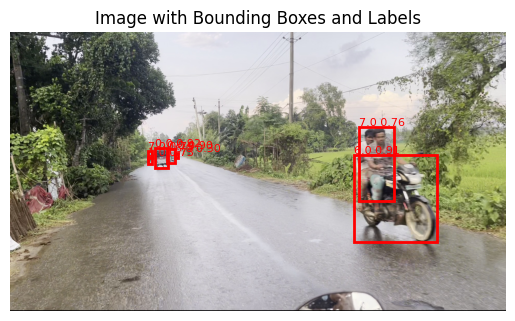

400it [01:12,  5.55it/s]

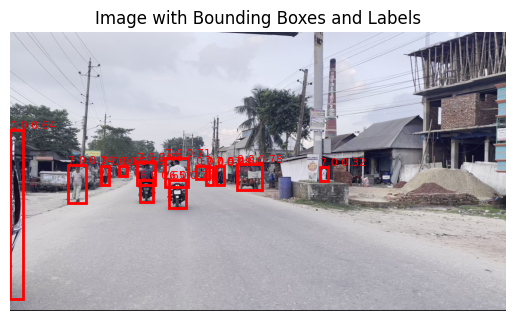

800it [02:22,  5.62it/s]

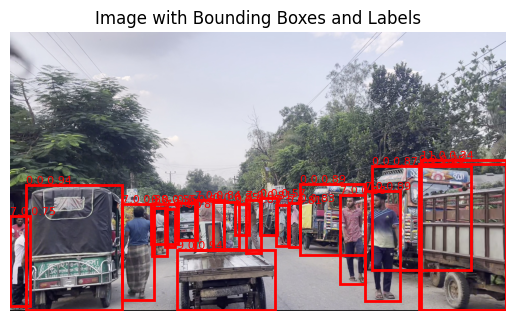

1200it [03:33,  5.52it/s]

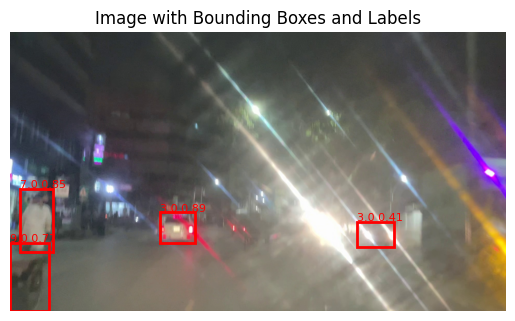

1600it [04:43,  5.65it/s]

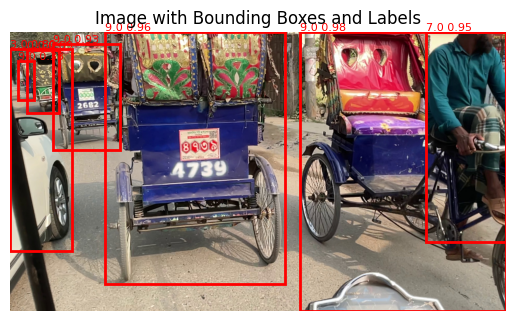

1964it [05:47,  5.65it/s]


In [12]:
# Directory path containing test images
test_directory = "/kaggle/input/dl-enigma-10-sust-cse-carnival-2024/dlenigma1/BadODD/images/test"

# Load the two models
model1 = RTDETR('/kaggle/input/model1rtdetr-epoch100/last (2).pt')
model2 = RTDETR('/kaggle/input/model2rtdetr-epoch60/best.pt')

# do the inference ...

def predict_all_files(test_directory):
    predictions = []
    for i,filename in tqdm(enumerate(os.listdir(test_directory))):
        if filename.endswith(".jpg"):
            filepath = os.path.join(test_directory, filename)
            boxes=[]
            scores=[]
            classes=[]
            
#           model1
            results = model1.predict(source=filepath, conf=0.50, verbose=False)
            boxes.append(get_boxes(boxes = results[0].boxes.xywhn.cpu().numpy()))
            scores.append(results[0].boxes.conf.cpu().numpy())
            classes.append(results[0].boxes.cls.cpu().numpy())
            
#           model2
            results = model2.predict(source=filepath, conf=0.50, verbose=False)
            boxes.append(get_boxes(boxes = results[0].boxes.xywhn.cpu().numpy()))
            scores.append(results[0].boxes.conf.cpu().numpy())
            classes.append(results[0].boxes.cls.cpu().numpy())
            
#           WBF(weight boxes fusion)
            boxes, scores, classes = weighted_boxes_fusion(boxes, scores, classes, weights=[1,1], iou_thr=0.35, skip_box_thr=0.001)
            
#           printing some prediction
            if(i%400==0) :
               showim_xyxy(filepath,boxes,classes,scores)
                
            prediction = get_prediction_entry(i, filename, boxes, scores, classes)
            predictions.append(prediction)
            
#             to csv format ...
    predictions_df = pd.DataFrame(predictions)
    predictions_df.to_csv("submission.csv", index=False)

# call the inference function ...
predict_all_files(test_directory)

# 🕵🏿‍♂️ Check Submission

In [14]:
df = pd.read_csv('/kaggle/working/submission.csv')
df.tail(5)

,id,ImageID,PredictionString_pred
1959,1959,mymensingh1_90013,0.0 0.9548465013504028 0.24851126968860626 0.0...
1960,1960,chittagong_bohoddarhat2_8673,3.0 0.9045611619949341 0.4668318033218384 0.70...
1961,1961,sylhet1_32475,0.0 0.9772832989692688 0.6574310064315796 0.04...
1962,1962,chittagong_night1_12840,3.0 0.889403223991394 0.22529488801956177 0.66...
1963,1963,chuadanga_sirajganj1_10320,11.0 0.9335304498672485 0.34269654750823975 0....


# 📢 References and Acknowledgement
* Some ideas of this notebook is form [Great-Barrier-Reef: YOLOv5 [infer] 🌊](https://www.kaggle.com/awsaf49/great-barrier-reef-yolov5-infer)
* Image 1 is taken from the [Competition](https://www.kaggle.com/competitions/dl-enigma-10-sust-cse-carnival-2024/overview) main page
* Image 2 is taken from [Original Paper](https://arxiv.org/pdf/1910.13302.pdf)
* Image 3 is from [This blog](https://m.somewhereinblog.net/)

<div style="text-align: center;">
    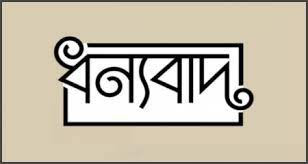
</div>